In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pybedtools
pybedtools.set_bedtools_path('/tscc/nfs/home/hsher/miniconda3/envs/my_metadensity/bin/')
from pybedtools import BedTool
from scipy.stats import zscore
import numpy as np
from sklearn.linear_model import LinearRegression
from plot_params import *


def fit_regression(raw_counts, total_reads, pseudocount_nread = 10, rsquare_threshold = 0.8):
    ''' given raw counts, perform regression and return deviation z-score '''
    
    individual_coef_df = []
    y_dev_df = []
    pseudocount = total_reads.div(total_reads.sum())*pseudocount_nread
    
    for index, row in raw_counts.iterrows():
        
        frac_table = pd.concat([total_reads, 
                                (row+pseudocount)/total_reads],
                  axis = 1)
        
        frac_table.columns = ['#total reads', f'fraction']

        X=np.log(frac_table[['#total reads']])
        y=np.log(frac_table[[f'fraction']])
        reg = LinearRegression().fit(X,y)
        reg_score=reg.score(X,y)
        coef=reg.coef_
        intercept=reg.intercept_

        if reg_score > rsquare_threshold and coef < 0:
            # detect outlier
            y_hat = reg.predict(X)
            y_dev = y-y_hat
            frac_table[index]=y_dev

            y_dev_df.append(frac_table[index])

        individual_coef_df.append([index, reg_score, coef[0,0], intercept[0]])
    individual_coef_df = pd.DataFrame(individual_coef_df, columns = ['name', 'R_square', 'coef', 'intercept'])
    y_dev_df = pd.concat(y_dev_df, axis = 1).T
    
    # calculate deviation z-score
    deviation_zscore = np.reshape(zscore(y_dev_df.values.flatten()), y_dev_df.shape)
    deviation_zscore = pd.DataFrame(deviation_zscore, index = y_dev_df.index, columns = y_dev_df.columns)
    
    return deviation_zscore, individual_coef_df


def generate_repeat_family_mask(repeat_family_to_mask, repeat_annotation, total_reads,
                                raw_counts, 
                                pseudocount_nread = 10, rsquare_threshold = 0.8):
    '''
    Generate repeat family mask by checking all repeat families that has a high noise type.
    For each "repeat name", perform the regression, and save the deviation from the regression line, 
    as the standard to be masked or not
    '''
    repeat_name_to_mask = repeat_annotation.loc[repeat_annotation['repFamily'].isin(repeat_family_to_mask), 'repName'].unique()
    
    deviation_zscore, individual_coef_df = fit_regression(raw_counts.loc[raw_counts.index.isin(repeat_name_to_mask)]
                                                          , total_reads, pseudocount_nread = pseudocount_nread,
                                                         rsquare_threshold = rsquare_threshold)
    
    return deviation_zscore, individual_coef_df
    


    
def generate_genome_mask(genome_transcript_types_to_mask, genomic_annotation, total_reads, 
                                genome_counts,
                                pseudocount_nread = 10, rsquare_threshold = 0.8):
    '''
    Generate genome window mask by checking all transcript types that has a high noise type.
    For each "window", perform the regression, and save the deviation from the regression line, 
    as the standard to be masked or not
    '''
    windows_to_mask = genomic_annotation.loc[genomic_annotation['transcript_type_top'].isin(genome_transcript_types_to_mask), 'name']
    
    deviation_zscore, individual_coef_df = fit_regression(genome_counts.loc[genome_counts.index.isin(windows_to_mask)]
                                                          , total_reads, pseudocount_nread = pseudocount_nread,
                                                         rsquare_threshold = rsquare_threshold)
    return deviation_zscore, individual_coef_df



In [2]:

basedir=  Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'
rsquare_threshold = 0.2 # how good the regression has to be
zscore_cutoff = 2 # how much does the rbp-rna interaction has to deviate from the noise regression to not be masked
genomic_annotation = pd.read_csv('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz',
                                 sep = '\t')
repeat_annotation = pd.read_csv('/tscc/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/repeatmasker.grch38.tsv.gz', sep = '\t')
##### read in all the files #####
# counts
raw_counts = pd.read_csv(basedir/'counts'/'repeats'/'megatables'/'name'/f'{out_stem}.tsv.gz', sep = '\t', index_col = 0)
genome_counts = pd.read_csv(basedir/'counts'/'genome'/'megatables'/f'{out_stem}.tsv.gz', sep = '\t')
genome_counts.index = genome_counts.index+1

total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)


# # megaoutputs: to mask, and contains annotations
# megaoutputs = pd.read_csv(basedir/'DMM_repeat'/'name'/f'{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)
# megaoutputs_genome = pd.read_csv(basedir/'DMM'/f'{out_stem}.megaoutputs.tsv', sep = '\t')
# megaoutputs_genome.set_index('name', inplace = True)



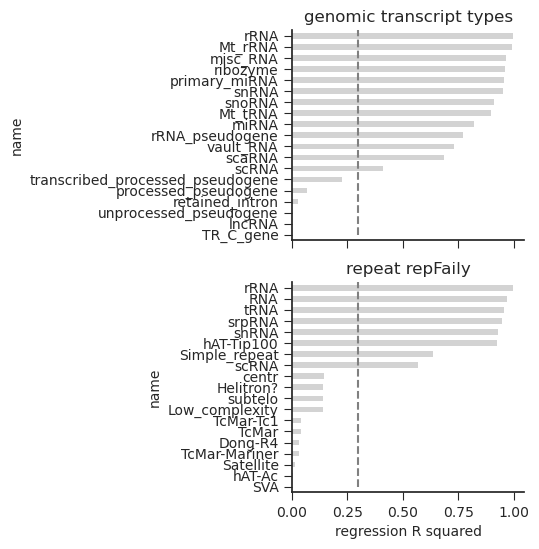

In [3]:

rep_family_counts = []
for family in repeat_annotation['repFamily'].unique():
    cnt = raw_counts.loc[raw_counts.index.isin(repeat_annotation.loc[repeat_annotation['repFamily']==family, 'repName'])
                                      ].sum(axis = 0)
    cnt.name = family
    rep_family_counts.append(cnt)
rep_family_counts = pd.concat(rep_family_counts, axis = 1).T
_, rep_coef_df = fit_regression(rep_family_counts, total_reads, rsquare_threshold = rsquare_threshold)


genome_counts['transcript_type_top']=genomic_annotation.set_index('name')['transcript_type_top']

transcript_type_counts = genome_counts.groupby(by = 'transcript_type_top').sum()
genome_counts.drop('transcript_type_top', inplace = True, axis = 1)
_, genome_coef_df = fit_regression(transcript_type_counts, total_reads, rsquare_threshold = rsquare_threshold)

f, axes = plt.subplots(2,1, figsize = (3,6), sharex = True)
genome_coef_df.loc[genome_coef_df['coef']<0].set_index('name')['R_square'].sort_values().iloc[-30:].plot.barh(
    ax = axes[0], color = 'lightgrey')
rep_coef_df.loc[rep_coef_df['coef']<0].set_index('name')['R_square'].sort_values().iloc[-30:].plot.barh(
    ax = axes[1], color = 'lightgrey')
axes[0].set_title('genomic transcript types')
axes[1].set_title('repeat repFaily')
_ = [ax.vlines(x=0.3, ymin = 0, ymax = 30, color = 'grey', linestyle = '--') for ax in axes]
plt.xlabel('regression R squared')
sns.despine()
plt.savefig(basedir / 'mask' / f'{out_stem}.category_coefficient.pdf')

genome_coef_df['type']='genome'
rep_coef_df['type']='repeat'
pd.concat([genome_coef_df, rep_coef_df], axis = 0).to_csv(basedir / 'mask' / f'{out_stem}.category_coefficient.csv') 
# this saves the regression outputs
    
plt.savefig(figdir/ 'repeat_family_to_mask.pdf')

In [4]:
rep_coef_df.loc[rep_coef_df['name']=='Crypton']

,name,R_square,coef,intercept,type
62,Crypton,0.080062,0.159666,-15.726398,repeat


In [5]:
rep_coef_df['sum'] = rep_coef_df['name'].map(rep_family_counts.sum(axis = 1))

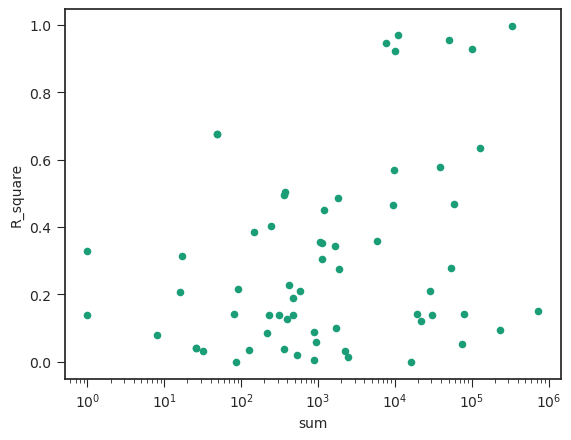

In [6]:
rep_coef_df.plot.scatter(x = 'sum', y = 'R_square')
plt.xscale('log')

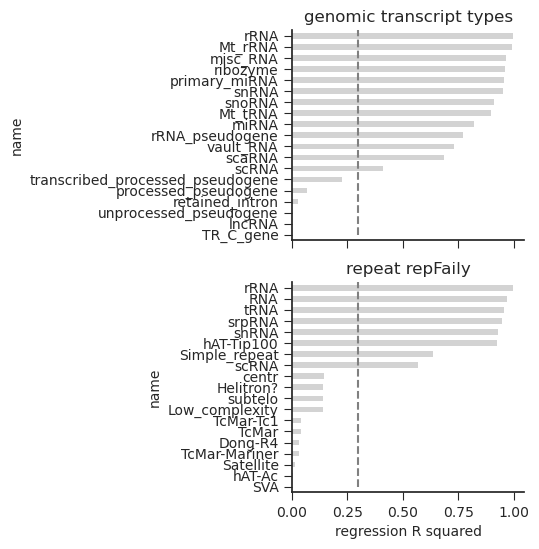

In [7]:
f, axes = plt.subplots(2,1, figsize = (3,6), sharex = True)
genome_coef_df.loc[genome_coef_df['coef']<0].set_index('name')['R_square'].sort_values().iloc[-30:].plot.barh(
    ax = axes[0], color = 'lightgrey')
rep_coef_df.loc[rep_coef_df['coef']<0].set_index('name')['R_square'].sort_values().iloc[-30:].plot.barh(
    ax = axes[1], color = 'lightgrey')
axes[0].set_title('genomic transcript types')
axes[1].set_title('repeat repFaily')
_ = [ax.vlines(x=0.3, ymin = 0, ymax = 30, color = 'grey', linestyle = '--') for ax in axes]
plt.xlabel('regression R squared')
sns.despine()
#plt.savefig(basedir / 'mask' / f'{out_stem}.category_coefficient.pdf')

genome_coef_df['type']='genome'
rep_coef_df['type']='repeat'
pd.concat([genome_coef_df, rep_coef_df], axis = 0).to_csv(basedir / 'mask' / f'{out_stem}.category_coefficient.csv') 
# this saves the regression outputs
    

In [8]:
def main(rsquare_threshold, zscore_cutoff):
    repeat_family_to_mask = rep_coef_df.loc[(rep_coef_df['coef']<0)&(rep_coef_df['R_square'].ge(rsquare_threshold)),'name'].tolist()
    genome_transcript_types_to_mask = genome_coef_df.loc[(genome_coef_df['coef']<0)&(genome_coef_df['R_square'].ge(rsquare_threshold)),'name'].tolist()
    print(f'family will be soft-masked: {len(repeat_family_to_mask)} {len(genome_transcript_types_to_mask)}')
    
    # get individual repeat name coefficients and y_dev
    zscore_dev_df, individual_coef_df = generate_repeat_family_mask(repeat_family_to_mask, repeat_annotation, total_reads,
                                    raw_counts,  rsquare_threshold=rsquare_threshold)
    
    fraction_total_masked = zscore_dev_df.le(2).all(axis = 1).sum()/individual_coef_df.shape[0]
    repeats_total_masked = zscore_dev_df.loc[zscore_dev_df.le(zscore_cutoff).all(axis = 1)].index
    
    
    # get individual repeat name coefficients and y_dev
    zscore_dev_df_genome, individual_coef_df_genome = generate_genome_mask(
    genome_transcript_types_to_mask, genomic_annotation, total_reads,
                                genome_counts, rsquare_threshold=rsquare_threshold)
    
    fraction_total_masked = zscore_dev_df_genome.le(2).all(axis = 1).sum()/individual_coef_df_genome.shape[0]
    genomic_total_masked = genomic_annotation.loc[
        genomic_annotation['name'].isin(
        zscore_dev_df_genome.loc[zscore_dev_df_genome.le(zscore_cutoff).all(axis = 1)].index)
    , 'gene_name'].unique()
    
#     zscore_dev_df_genome.to_csv(basedir / 'mask' / f'{out_stem}.genome_deviation_zscore.csv') # this saves the regression outputs
#     zscore_dev_df_genome.ge(zscore_cutoff).to_csv(basedir / 'mask' / f'{out_stem}.genome_mask.csv') # this saves the regression outputs
#     individual_coef_df_genome.to_csv(basedir / 'mask' / f'{out_stem}.genome_window_regcoef.csv') # this saves the regression outputs

#     zscore_dev_df.to_csv(basedir / 'mask' / f'{out_stem}.repeat_deviation_zscore.csv') # this saves the regression outputs
#     individual_coef_df.to_csv(basedir / 'mask' / f'{out_stem}.repeat_window_regcoef.csv') # this saves the regression outputs
#     zscore_dev_df.ge(zscore_cutoff).to_csv(basedir / 'mask' / f'{out_stem}.repeat_mask.csv') # this saves the regression outputs
    
    return zscore_dev_df_genome, zscore_dev_df_genome.ge(zscore_cutoff),zscore_dev_df, zscore_dev_df.ge(zscore_cutoff)

In [9]:
nread = 10
raw_counts = raw_counts.loc[raw_counts.sum(axis = 1)>nread]
genome_counts = genome_counts.loc[genome_counts.sum(axis = 1)>nread]
result = {}
for rsquare in [0.1, 0.3, 0.5, 0.8]:
    print(f'computing {rsquare}')
    result[rsquare] = main(rsquare, 2)
    print(result[rsquare][0].shape[0])

computing 0.1
family will be soft-masked: 12 14
562
computing 0.3
family will be soft-masked: 8 13
500
computing 0.5
family will be soft-masked: 8 12
434
computing 0.8
family will be soft-masked: 6 9
262


# Evaluate

In [10]:
megaoutputs = pd.read_csv(basedir/'DMM_repeat'/'name'/f'{out_stem}.megaoutputs_unmasked.tsv', sep = '\t', index_col = 0)
megaoutputs_masked = pd.read_csv(basedir/'DMM_repeat'/'name'/f'{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)

megaoutputs_genome = pd.read_csv(basedir/'DMM'/f'{out_stem}.megaoutputs_unmasked.tsv', sep = '\t')
megaoutputs_genome.set_index('name', inplace = True)
megaoutputs_genome_masked = pd.read_csv(basedir/'DMM'/f'{out_stem}.megaoutputs.tsv', sep = '\t')
megaoutputs_genome_masked.set_index('name', inplace = True)

In [11]:
# gather ground_truth from eCLIP: repeats
rbps = [r.split('.')[1] for r in megaoutputs.columns[megaoutputs.columns.str.startswith(out_stem)]]
rbps.remove('DDX3')
rbps+=['DDX3X']

ground_truth_skipper = []
l2or_enrichment = []
for rbp in rbps:
    f = Path('/tscc/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_re')/f'{rbp}_K562.reproducible_enriched_re.tsv.gz'
    df = pd.read_csv(f, sep = '\t')
    df[rbp]=True
    value = df.set_index('repeat_name')[rbp]
    ground_truth_skipper.append(value)
    
    value=df.set_index('repeat_name')['enrichment_l2or_mean']
    value.name = rbp
    l2or_enrichment.append(value)
ground_truth_skipper = pd.concat(ground_truth_skipper, axis = 1).fillna(False).rename({'DDX3X': 'DDX3'}, axis = 1)
ground_truth_skipper_l2or = pd.concat(l2or_enrichment, axis = 1).fillna(0).rename({'DDX3X': 'DDX3'}, axis = 1)
ground_truth_skipper = ground_truth_skipper.merge(megaoutputs, left_index = True, right_index = True, how = 'right')[ground_truth_skipper.columns].fillna(False)
# eCLIP ground truth, genome
ground_truth_skipper_genome = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper_genome.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper_genome.sum().sort_values()
ground_truth_skipper_genome = ground_truth_skipper_genome.merge(megaoutputs_genome
                                                                , left_index = True, right_index = True, how = 'right')[ground_truth_skipper_genome.columns].fillna(False)

In [12]:
# benchmark genome, ydev, fc_raw and logLR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


In [13]:
all_data_dict = {}
for r in result.keys():
    genome_zscore = result[r][0]
    logLR = megaoutputs_genome_masked.loc[genome_zscore.index, megaoutputs_genome_masked.columns.str.contains('logLR:')]
    p_raw = genome_counts.loc[genome_zscore.index].div(genome_counts.loc[genome_zscore.index].sum(axis = 1), axis = 0)
    fc_raw = p_raw.div(genome_counts.sum(axis = 0), axis = 1)
    truth = ground_truth_skipper_genome.loc[genome_zscore.index]
    all_data = truth.unstack().reset_index()
    all_data.columns = ['RBP', 'name', 'is_eCLIP']
    for values, value_name in zip([genome_zscore,logLR, fc_raw],
                                  ['deviation zscore','logLR','fc_raw']
                                 ):
        values = values.copy()
        values.columns = [c.split('.')[1] for c in values.columns]
        values_unstack = values.unstack().reset_index()
        values_unstack.columns = ['RBP', 'name', value_name]
        all_data = all_data.merge(values_unstack, left_on = ['RBP', 'name'], right_on = ['RBP', 'name'])
    
    all_data['transcript_type_top']=all_data['name'].map(megaoutputs_genome['transcript_type_top'])
    all_data['transcript_types']=all_data['name'].map(megaoutputs_genome['transcript_types'])
    
    all_data_dict[r]=all_data

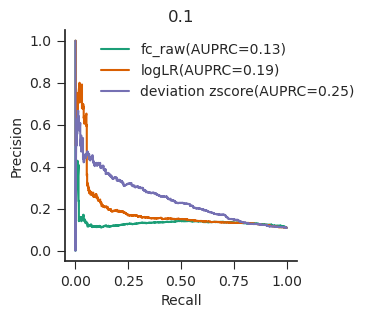

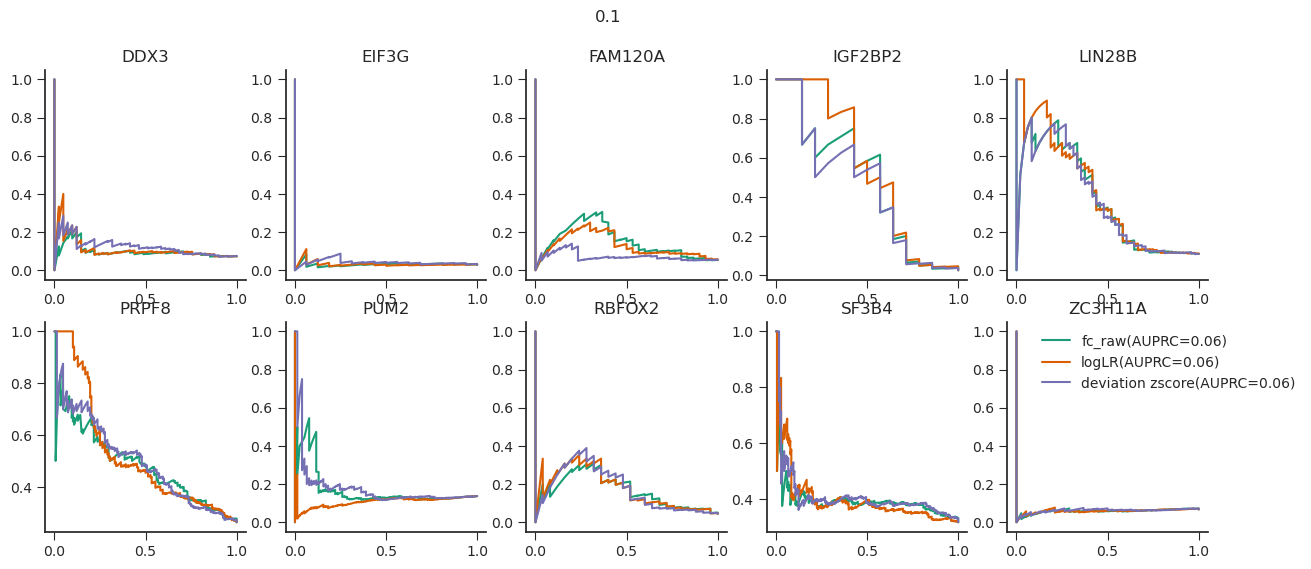

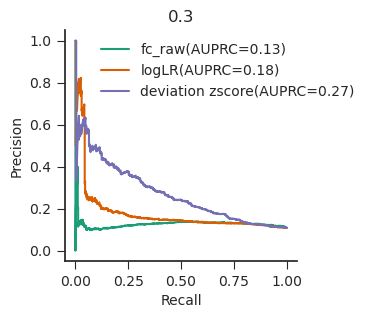

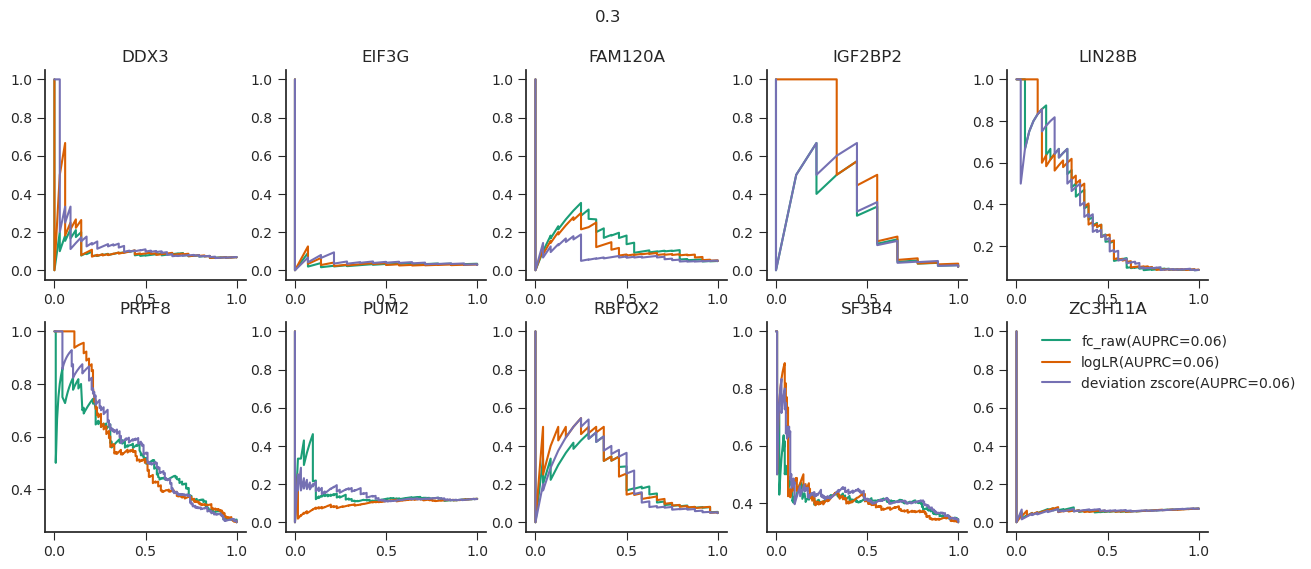

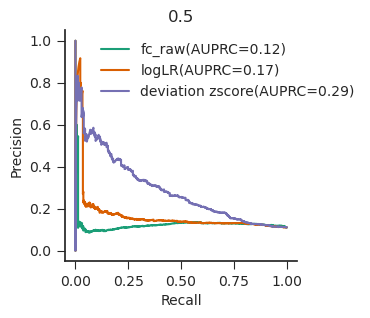

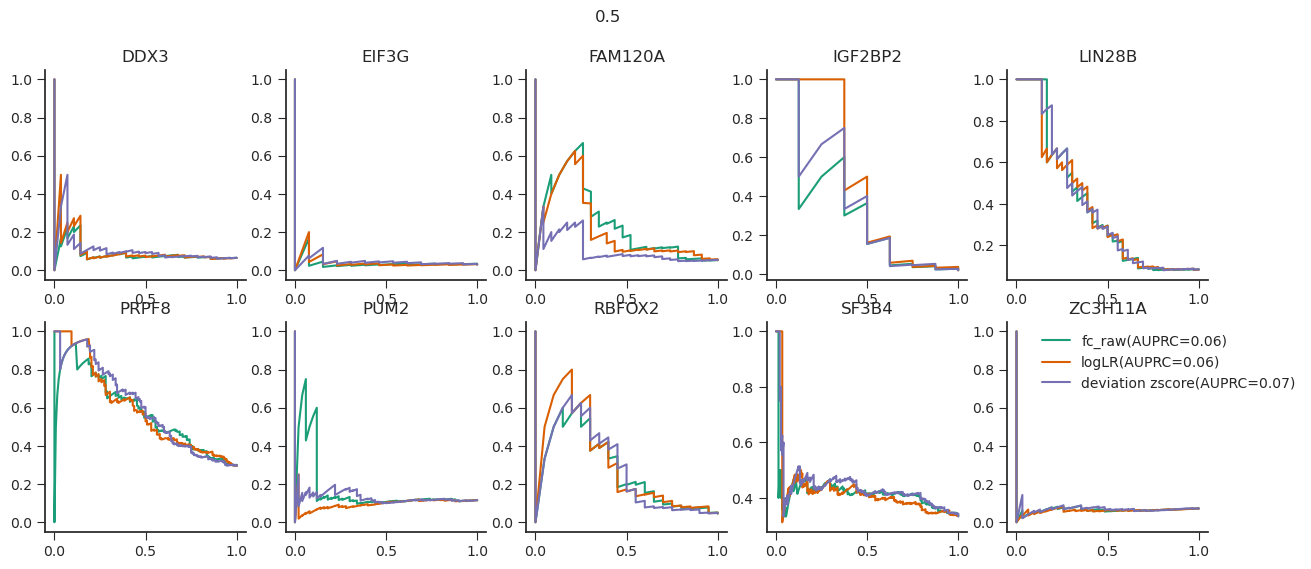

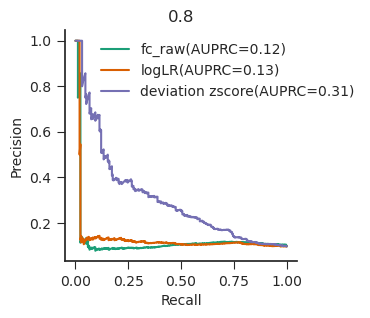

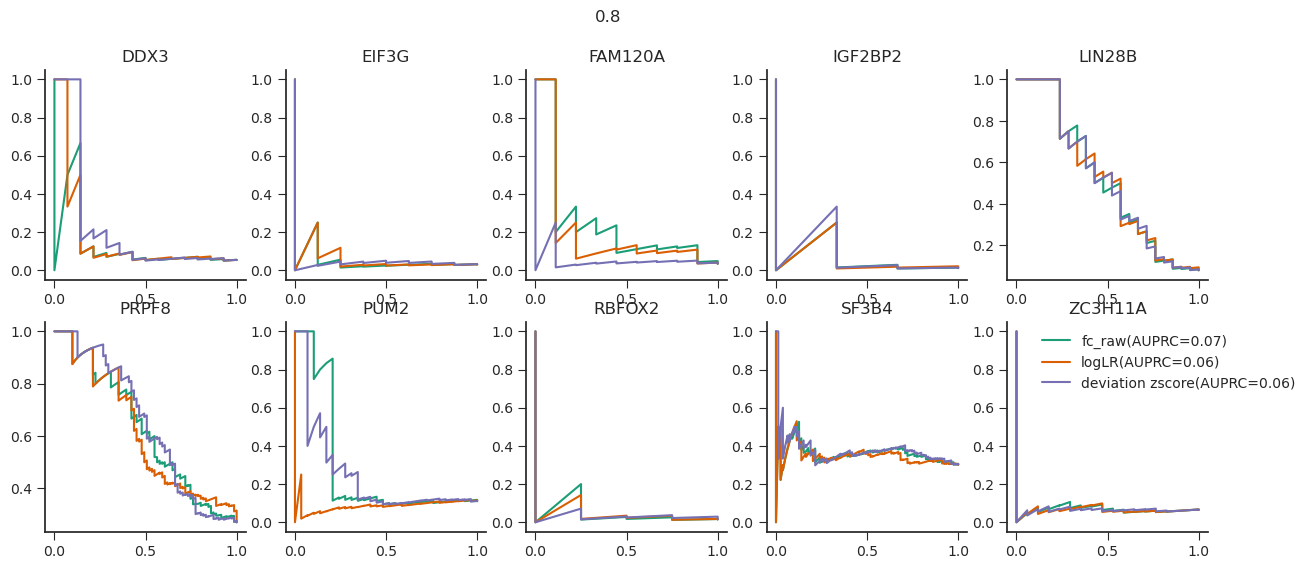

In [14]:
for r in all_data_dict.keys():
    all_data = all_data_dict[r]
    f, ax = plt.subplots(figsize = (3,3))
    truth = all_data['is_eCLIP']

    for col in ['fc_raw', 'logLR', 'deviation zscore']:
        precision, recall, thresholds = precision_recall_curve(truth, 
                                                                all_data[col])
        auprc = auc(recall, precision)
        ax.plot(recall, precision, label = f'{col}(AUPRC={auprc:.2f})')



    ax.legend(bbox_to_anchor = (1.3, 1))
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.set_title(f'{r}')
    sns.despine()
    plt.savefig(figdir/f'AUPRC_masking_genome_family_{r}.pdf')
    
    f, axes = plt.subplots(2,5, figsize = (15,6))
    for (name, group),ax in zip(all_data.groupby(by = 'RBP'), axes.flatten()):
        for col in ['fc_raw', 'logLR', 'deviation zscore']:
            precision, recall, thresholds = precision_recall_curve(group['is_eCLIP'], 
                                                                    group[col])
            auprc = auc(recall, precision)
            ax.plot(recall, precision, label = f'{col}(AUPRC={auprc:.2f})')
        ax.set_title(name)
    sns.despine()
    ax.legend(bbox_to_anchor = (1.5, 1))
    plt.suptitle(f'{r}')

In [15]:
all_data_dict_repeat = {}
for r in result.keys():
    repeat_zscore = result[r][2]
    logLR = megaoutputs_masked.loc[repeat_zscore.index, megaoutputs_masked.columns.str.contains('logLR:')]
    p_raw = raw_counts.loc[repeat_zscore.index].div(raw_counts.loc[repeat_zscore.index].sum(axis = 1), axis = 0)
    fc_raw = p_raw.div(raw_counts.sum(axis = 0), axis = 1)
    truth = ground_truth_skipper.loc[repeat_zscore.index]
    all_data = truth.unstack().reset_index()
    all_data.columns = ['RBP', 'name', 'is_eCLIP']
    for values, value_name in zip([repeat_zscore,logLR, fc_raw],
                                  ['deviation zscore','logLR','fc_raw']
                                 ):
        values = values.copy()
        values.columns = [c.split('.')[1] for c in values.columns]
        values_unstack = values.unstack().reset_index()
        values_unstack.columns = ['RBP', 'name', value_name]
        all_data = all_data.merge(values_unstack, left_on = ['RBP', 'name'], right_on = ['RBP', 'name'])
        
    
    all_data['repFamily']=all_data['name'].map(megaoutputs['repFamily'])
    
    all_data_dict_repeat[r]=all_data
    

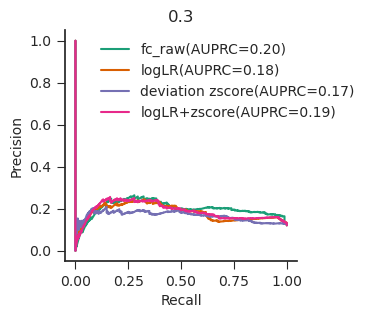

In [16]:
f, ax = plt.subplots(figsize = (3,3))
r=0.3
all_data = all_data_dict_repeat[r]
all_data['logLR+zscore']=all_data['logLR']+all_data['deviation zscore']
for col in ['fc_raw', 'logLR', 'deviation zscore','logLR+zscore']:
    truth = all_data['is_eCLIP']
    precision, recall, thresholds = precision_recall_curve(truth, 
                                                            all_data[col])
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'{col}(AUPRC={auprc:.2f})')



ax.legend(bbox_to_anchor = (1.3, 1))
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title(f'{r}')
sns.despine()
plt.savefig(figdir/f'AUPRC_masking_repeat_family_{r}.pdf')

In [17]:
all_data['label_unmasked']=all_data['logLR'].ge(2)
all_data['label_masked']=all_data['logLR'].ge(2)&all_data['deviation zscore'].ge(2)

In [18]:
from sklearn.metrics import f1_score
f1_score(all_data['is_eCLIP'], all_data['label_masked']),f1_score(all_data['is_eCLIP'], all_data['label_unmasked'])

(0.017937219730941704, 0.29259896729776247)

In [19]:
all_data.loc[all_data['is_eCLIP']&all_data['label_unmasked'], 'repFamily'].value_counts()

tRNA             74
snRNA             7
scRNA             2
Simple_repeat     1
hAT-Tip100        1
Name: repFamily, dtype: int64

In [20]:
all_data.loc[all_data['is_eCLIP']&all_data['label_masked'], 'repFamily'].value_counts()

snRNA    2
Name: repFamily, dtype: int64

In [21]:
all_data.loc[all_data['is_eCLIP']&all_data['label_masked']]

,RBP,name,is_eCLIP,deviation zscore,logLR,fc_raw,repFamily,logLR+zscore,label_unmasked,label_masked
997,PRPF8,U6,True,2.038614,3.705650,8.470664e-07,snRNA,5.744264,True,True
1295,SF3B4,U2,True,2.148470,3.663447,8.301012e-07,snRNA,5.811917,True,True


In [22]:
tRNA_lost=all_data.loc[all_data['is_eCLIP']&all_data['label_unmasked']&(~all_data['label_masked'])&(all_data['repFamily']=='tRNA'), 'name'].unique()

In [23]:
tRNA_lost

array(['tRNA-Asp-GAY', 'tRNA-Gln-CAG', 'tRNA-Glu-GAG', 'tRNA-Gly-GGA',
       'tRNA-His-CAY_', 'tRNA-Pro-CCA', 'tRNA-Pro-CCY', 'tRNA-Ser-TCY',
       'tRNA-Thr-ACY_', 'tRNA-Leu-TTA(m)', 'tRNA-Lys-AAA', 'tRNA-Ala-GCA',
       'tRNA-Ala-GCG', 'tRNA-Ala-GCY_', 'tRNA-Arg-AGA', 'tRNA-Arg-AGG',
       'tRNA-Arg-CGA_', 'tRNA-Arg-CGG', 'tRNA-Arg-CGY_', 'tRNA-Asn-AAC',
       'tRNA-Cys-TGY', 'tRNA-Gln-CAA', 'tRNA-Glu-GAA', 'tRNA-Gly-GGY',
       'tRNA-Ile-ATT', 'tRNA-Leu-CTA', 'tRNA-Leu-TTA', 'tRNA-Lys-AAG',
       'tRNA-Met', 'tRNA-Met-i', 'tRNA-Met_', 'tRNA-SeC(e)-TGA',
       'tRNA-Ser-AGY', 'tRNA-Ser-TCA', 'tRNA-Thr-ACA', 'tRNA-Thr-ACG',
       'tRNA-Thr-ACG_', 'tRNA-Thr-ACY', 'tRNA-Tyr-TAC', 'tRNA-Val-GTA',
       'tRNA-Ala-GCY', 'tRNA-Ile-ATA', 'tRNA-Phe-TTY', 'tRNA-Val-GTG',
       'tRNA-Val-GTY', 'tRNA-Gln-CAA_'], dtype=object)

In [24]:
(ground_truth_skipper.loc[ground_truth_skipper.index.str.startswith('tRNA')].sum(axis = 1))[tRNA_lost].sort_values().ge(3).mean()

0.5869565217391305

In [25]:
ground_truth_skipper_all = []
l2or_enrichment = []
for f in Path('/tscc/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_re').glob('*.reproducible_enriched_re.tsv.gz'):
    rbp = f.name.split('.')[0]
    df = pd.read_csv(f, sep = '\t')
    df[rbp]=True
    value = df.set_index('repeat_name')[rbp]
    ground_truth_skipper_all.append(value)
    
    value=df.set_index('repeat_name')['enrichment_l2or_mean']
    value.name = rbp
    l2or_enrichment.append(value)
ground_truth_skipper_all = pd.concat(ground_truth_skipper_all, axis = 1).fillna(False).rename({'DDX3X': 'DDX3'}, axis = 1)

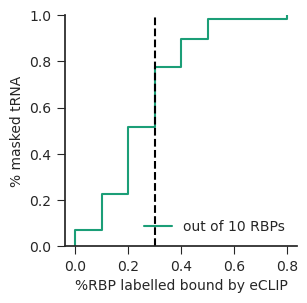

In [26]:
f, ax = plt.subplots(figsize = (3,3))
sns.ecdfplot(ground_truth_skipper.loc[ground_truth_skipper.index.str.startswith('tRNA')].mean(axis = 1),
            ax = ax, label = 'out of 10 RBPs')
# sns.ecdfplot(ground_truth_skipper_all.loc[ground_truth_skipper_all.index.str.startswith('tRNA')].mean(axis = 1),
#              ax =ax, label = 'all ENCODE 3 eCLIP')
ax.vlines(x = 0.3, ymin = 0, ymax = 1, linestyle='--', color = 'black')
plt.xlabel('%RBP labelled bound by eCLIP')
plt.ylabel('% masked tRNA')
ax.legend()
sns.despine()
plt.savefig(figdir/f'tRNA_is_bound.pdf')

# Some descriptive statistics

In [27]:
zscore_genome = pd.read_csv(basedir/ 'mask' / f'{out_stem}.genome_deviation_zscore.csv', index_col = 0)
zscore_repeat = pd.read_csv(basedir / 'mask' / f'{out_stem}.repeat_deviation_zscore.csv', index_col = 0)

In [28]:
zscore_genome.shape, zscore_repeat.shape

((508, 10), (172, 10))

## How many is skipper and eclip

In [29]:
considered_genomic_windows = BedTool.from_dataframe(genomic_annotation[['chrom', 'start', 'end', 'name', 'score', 'strand']])
skipper_blacklist = BedTool('/tscc/projects/ps-yeolab4/software/skipper/bb63a25/bin/skipper/annotations/encode3_eclip_blacklist.bed').intersect(considered_genomic_windows, s = True)
eclip_blacklist = BedTool('/tscc/projects/ps-yeolab4/software/eclip/0.7.1/examples/inputs/eCLIP_blacklistregions.hg38liftover.bed.fixed.bed').intersect(considered_genomic_windows, s = True)

In [30]:
genomic_blacklist_bed = BedTool.from_dataframe(genomic_annotation.loc[genomic_annotation['name'].isin(zscore_genome.index),
                                              ['chrom', 'start', 'end', 'name', 'score', 'strand']
                                                                     ])

In [31]:
len(genomic_blacklist_bed.intersect(skipper_blacklist))/len(genomic_blacklist_bed)

0.28937007874015747

In [32]:
len(genomic_blacklist_bed.intersect(eclip_blacklist))/len(genomic_blacklist_bed)

0.001968503937007874

In [33]:
len(genomic_blacklist_bed.intersect(eclip_blacklist))/len(eclip_blacklist)

0.030303030303030304

In [34]:
megaoutputs_genome.loc[megaoutputs_genome.index.isin(zscore_genome.index), megaoutputs_genome.columns.str.startswith(out_stem)].sum().mean()

40.9

In [35]:
megaoutputs_genome.loc[megaoutputs_genome.index.isin(zscore_genome.index), megaoutputs_genome.columns.str.startswith(out_stem)].sum()

K562_rep6.IGF2BP2      3
K562_rep6.RBFOX2      15
K562_rep6.PUM2       211
K562_rep6.FAM120A      0
K562_rep6.DDX3         8
K562_rep6.ZC3H11A    106
K562_rep6.EIF3G        9
K562_rep6.PRPF8       30
K562_rep6.LIN28B      24
K562_rep6.SF3B4        3
dtype: int64

# what is being masked

In [36]:
diff = (megaoutputs_genome.loc[:, megaoutputs_genome.columns.str.startswith(out_stem)]!=megaoutputs_genome_masked.loc[:, megaoutputs_genome_masked.columns.str.startswith(out_stem)])

In [37]:
# % masked
diff.sum()/megaoutputs_genome.loc[megaoutputs_genome.index.isin(zscore_genome.index), megaoutputs_genome.columns.str.startswith(out_stem)].sum()

K562_rep6.IGF2BP2    0.000000
K562_rep6.RBFOX2     0.000000
K562_rep6.PUM2       0.924171
K562_rep6.FAM120A         NaN
K562_rep6.DDX3       0.000000
K562_rep6.ZC3H11A    0.754717
K562_rep6.EIF3G      0.333333
K562_rep6.PRPF8      0.000000
K562_rep6.LIN28B     0.000000
K562_rep6.SF3B4      0.000000
dtype: float64

In [38]:
diff['transcript_type_top']=megaoutputs_genome['transcript_type_top']

In [39]:
diff_cnt = []
for c in diff.columns:
    if c.startswith(out_stem):
        cnts = diff.loc[diff[c], 'transcript_type_top'].value_counts()
        cnts.name = c
        diff_cnt.append(cnts)
diff_cnt = pd.concat(diff_cnt, axis = 1).fillna(0)

In [40]:
diff_cnt

,K562_rep6.IGF2BP2,K562_rep6.RBFOX2,K562_rep6.PUM2,K562_rep6.FAM120A,K562_rep6.DDX3,K562_rep6.ZC3H11A,K562_rep6.EIF3G,K562_rep6.PRPF8,K562_rep6.LIN28B,K562_rep6.SF3B4
snoRNA,0.0,0.0,63,0.0,0.0,13.0,0.0,0.0,0.0,0.0
snRNA,0.0,0.0,50,0.0,0.0,27.0,2.0,0.0,0.0,0.0
misc_RNA,0.0,0.0,29,0.0,0.0,3.0,0.0,0.0,0.0,0.0
Mt_rRNA,0.0,0.0,24,0.0,0.0,26.0,0.0,0.0,0.0,0.0
primary_miRNA,0.0,0.0,12,0.0,0.0,5.0,1.0,0.0,0.0,0.0
miRNA,0.0,0.0,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ribozyme,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rRNA,0.0,0.0,4,0.0,0.0,4.0,0.0,0.0,0.0,0.0
scaRNA,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mt_tRNA,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0


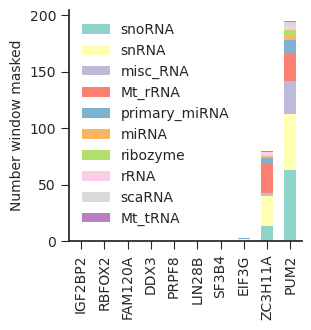

In [41]:
sns.set_palette('Set3')
diff_cnt.columns = [c.split('.')[1] for c in diff_cnt.columns]
diff_cnt.loc[:,diff_cnt.sum(axis = 0).sort_values().index].T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('Number window masked')
sns.despine()
plt.savefig(figdir/'n_mask.pdf')

In [42]:
diff_repeat = (megaoutputs.loc[:, megaoutputs.columns.str.startswith(out_stem)]!=
        megaoutputs_masked.loc[:, megaoutputs_masked.columns.str.startswith(out_stem)])
diff_repeat['repFamily']=megaoutputs['repFamily']

In [43]:
diff_cnt_repeat = []
for c in diff_repeat.columns:
    if c.startswith(out_stem):
        cnts = diff_repeat.loc[diff_repeat[c], 'repFamily'].value_counts()
        cnts.name = c
        diff_cnt_repeat.append(cnts)
diff_cnt_repeat = pd.concat(diff_cnt_repeat, axis = 1).fillna(0)

In [44]:
diff_cnt_repeat

,K562_rep6.IGF2BP2,K562_rep6.RBFOX2,K562_rep6.PUM2,K562_rep6.FAM120A,K562_rep6.DDX3,K562_rep6.ZC3H11A,K562_rep6.EIF3G,K562_rep6.PRPF8,K562_rep6.LIN28B,K562_rep6.SF3B4
tRNA,0.0,0.0,46,0.0,44,26.0,51.0,0.0,26.0,0.0
Simple_repeat,0.0,0.0,14,0.0,14,11.0,17.0,0.0,3.0,0.0
snRNA,0.0,0.0,9,0.0,9,8.0,10.0,0.0,4.0,0.0
rRNA,0.0,0.0,3,0.0,3,3.0,3.0,0.0,2.0,0.0
scRNA,0.0,0.0,3,0.0,2,0.0,1.0,0.0,1.0,0.0
hAT-Tip100,0.0,0.0,2,0.0,2,2.0,2.0,0.0,0.0,0.0
RNA,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1.0,0.0
srpRNA,0.0,0.0,1,0.0,1,0.0,1.0,0.0,1.0,0.0


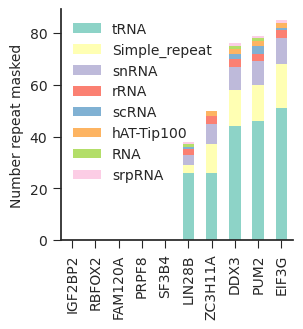

In [45]:
diff_cnt_repeat.columns = [c.split('.')[1] for c in diff_cnt_repeat.columns]
diff_cnt_repeat.loc[:,diff_cnt_repeat.sum(axis = 0).sort_values().index].T.plot.bar(stacked = True, figsize = (3,3))

plt.ylabel('Number repeat masked')
sns.despine()
plt.savefig(figdir/'n_mask_repeat.pdf')

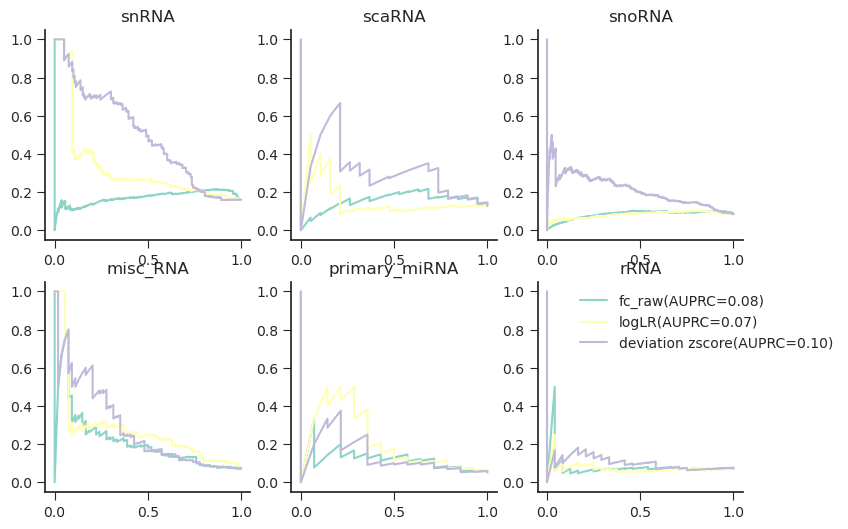

In [46]:
f, axes = plt.subplots(2,3, figsize = (9,6))
auprc_df = []
all_data = all_data_dict[0.3]
for name, ax in zip(all_data['transcript_type_top'].unique(), axes.flatten()):
    group = all_data.loc[all_data['transcript_types'].str.contains(name)]

    for col in ['fc_raw', 'logLR', 'deviation zscore']:
        if len(group['is_eCLIP'].unique())>1:
            precision, recall, thresholds = precision_recall_curve(group['is_eCLIP'], 
                                                                    group[col])
            auprc = auc(recall, precision)
            ax.plot(recall, precision, label = f'{col}(AUPRC={auprc:.2f})')
            ax.set_title(name)
            
            auprc_df.append([name, col, auprc])
sns.despine()
axes.flatten()[-1].legend(bbox_to_anchor = (1.5, 1))


In [47]:
all_data = all_data_dict_repeat[0.3]
for name in all_data['repFamily'].unique():
    group = all_data.loc[all_data['repFamily'].str.contains(name)]

    for col in ['fc_raw', 'logLR', 'deviation zscore']:
        if len(group['is_eCLIP'].unique())>1:
            precision, recall, thresholds = precision_recall_curve(group['is_eCLIP'], 
                                                                    group[col])
            auprc = auc(recall, precision)
            
            
            auprc_df.append([name, col, auprc])
sns.despine()
axes.flatten()[-1].legend(bbox_to_anchor = (1.5, 1))
auprc_df = pd.DataFrame(auprc_df, columns = ['RNA type', 'metric', 'AUPRC'])

<Figure size 640x480 with 0 Axes>

In [48]:
auprc_by_rnatype = pd.pivot_table(auprc_df, index = 'RNA type', columns = 'metric', values = 'AUPRC')

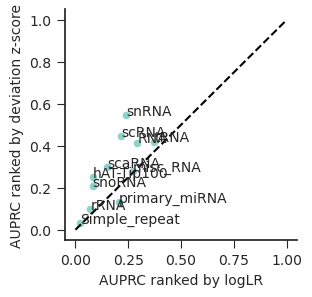

In [49]:
auprc_by_rnatype.plot.scatter(x = 'logLR', y = 'deviation zscore', figsize = (3,3))
plt.plot([0,1], [0,1], '--', color = 'black')

for index, row in auprc_by_rnatype.iterrows():
    plt.text(row['logLR'], row['deviation zscore'], index)
plt.xlabel('AUPRC ranked by logLR')
plt.ylabel('AUPRC ranked by deviation z-score')
sns.despine()
plt.savefig(figdir/'AUPRC_genome_by_RNAtype_scatter.pdf')

In [61]:
auprc_by_rnatype

metric,deviation zscore,fc_raw,logLR
RNA type,,,
RNA,0.415271,0.359596,0.292161
Simple_repeat,0.030785,0.022976,0.021585
hAT-Tip100,0.250000,0.100000,0.083333
misc_RNA,0.281158,0.207815,0.270712
primary_miRNA,0.133223,0.116954,0.205185
rRNA,0.098292,0.077222,0.071135
scRNA,0.446366,0.318317,0.215835
scaRNA,0.298846,0.153901,0.149615
snRNA,0.547110,0.183698,0.239240


In [50]:
(auprc_by_rnatype['deviation zscore']-auprc_by_rnatype['logLR']).sort_values()

RNA type
primary_miRNA   -0.071962
Simple_repeat    0.009200
misc_RNA         0.010446
rRNA             0.027157
tRNA             0.046257
RNA              0.123110
snoRNA           0.127584
scaRNA           0.149231
hAT-Tip100       0.166667
scRNA            0.230530
snRNA            0.307870
dtype: float64

In [51]:
from sklearn.metrics import f1_score
masked_dict = {}
for r in result.keys():
    genome_mask = result[r][1]
    masked = megaoutputs_genome.copy()
    masked.loc[genome_mask.index, genome_mask.columns] = masked.loc[genome_mask.index, genome_mask.columns]*genome_mask
    masked_dict[r] = masked


In [52]:
masked_dict['unmask']=megaoutputs_genome

In [53]:
all_f1 = []
for key in masked_dict:
    for rbp in ground_truth_skipper_genome.columns:
        f1 = f1_score(ground_truth_skipper_genome[rbp], 
                 masked_dict[key].loc[ground_truth_skipper_genome.index, f'{out_stem}.{rbp}'])
        all_f1.append([key, rbp, f1])

In [54]:
all_f1 = pd.DataFrame(all_f1, columns = ['masking Rsquare', 'RBP','F1'])

In [55]:
pd.pivot_table(all_f1, index = 'masking Rsquare', columns = 'RBP', values = 'F1')

RBP,DDX3,EIF3G,FAM120A,IGF2BP2,LIN28B,PRPF8,PUM2,RBFOX2,SF3B4,ZC3H11A
masking Rsquare,,,,,,,,,,
0.1,0.414485,0.024162,0.694096,0.377030,0.448894,0.441540,0.134571,0.381772,0.491297,0.168955
0.3,0.414419,0.024155,0.694096,0.377136,0.449055,0.441661,0.134905,0.381988,0.491297,0.168893
0.5,0.414419,0.024147,0.694096,0.377190,0.449083,0.441823,0.134879,0.381988,0.491297,0.168831
0.8,0.414419,0.024140,0.694096,0.377190,0.449186,0.441823,0.135130,0.381988,0.491297,0.168460
unmask,0.414419,0.024721,0.694096,0.377190,0.449186,0.441823,0.136406,0.381988,0.491297,0.168765


In [56]:
all_f1_sub = []
for transcript_type in genome_coef_df['name'].unique():
    subset_window = megaoutputs_genome.loc[
            megaoutputs_genome['transcript_type_top'].str.contains(transcript_type)].index
    print(subset_window.shape, transcript_type)
    for key in masked_dict:
        
        for rbp in ground_truth_skipper_genome.columns:
            if ground_truth_skipper_genome.loc[subset_window, rbp].sum()>0 and masked_dict[key].loc[subset_window, f'{out_stem}.{rbp}'].sum()>0:
                f1 = f1_score(ground_truth_skipper_genome.loc[subset_window, rbp], 
                         masked_dict[key].loc[subset_window, f'{out_stem}.{rbp}'])
                all_f1_sub.append([key, rbp, f1, transcript_type])

(0,) IG_V_gene
(0,) IG_V_pseudogene
(27,) Mt_rRNA
(16,) Mt_tRNA
(14,) TEC
(0,) TR_C_gene
(0,) TR_J_gene
(0,) TR_V_gene
(0,) TR_V_pseudogene
(4145,) lncRNA
(65,) miRNA
(148,) misc_RNA
(0,) non_stop_decay
(590,) nonsense_mediated_decay
(34,) primary_miRNA
(1146,) processed_pseudogene
(2688,) processed_transcript
(127777,) protein_coding
(1151,) pseudogene
(36,) rRNA
(5,) rRNA_pseudogene
(1341,) retained_intron
(7,) ribozyme
(2,) scRNA
(38,) scaRNA
(146,) snRNA
(337,) snoRNA
(15,) transcribed_processed_pseudogene
(458,) transcribed_unprocessed_pseudogene
(1,) translated_unprocessed_pseudogene
(889,) unprocessed_pseudogene
(2,) vault_RNA


In [57]:
all_f1_sub = pd.DataFrame(all_f1_sub, columns = ['masking Rsquare', 'RBP','F1', 'transcript type'])

In [58]:
pd.pivot_table(all_f1_sub.loc[all_f1_sub['transcript type']=='snRNA']
               , index = 'masking Rsquare', columns = 'RBP', values = 'F1')


RBP,LIN28B,PRPF8,PUM2,SF3B4,ZC3H11A
masking Rsquare,,,,,
0.1,0.148148,0.562500,0.000000,0.193548,NaN
0.3,0.142857,0.606061,0.000000,0.193548,NaN
0.5,0.142857,0.656934,0.000000,0.193548,NaN
0.8,0.142857,0.656934,0.060606,0.193548,0.00
unmask,0.142857,0.656934,0.170732,0.193548,0.15


In [59]:
cnt = []
for key in masked_dict.keys():
    df = masked_dict[key]
    n = df.loc[df[f'{out_stem}.PUM2'], 'feature_type_top'].value_counts()
    n.name = key
    cnt.append(n)
cnt = pd.concat(cnt, axis = 1)

In [60]:
cnt = []
for key in masked_dict.keys():
    df = masked_dict[key]
    n = df.loc[df[f'{out_stem}.PRPF8'], 'transcript_type_top'].value_counts()
    n.name = key
    cnt.append(n)
cnt = pd.concat(cnt, axis = 1)